# Creating a Databunch for Basecalling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *

import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.files as f

## Constants

In [3]:
BLANK_ID = prep.BLANK_ID
C = 5
D_in = 300
D_h = 201
D_out_max = 70
n_hidden = 200
BS = 64  # batch size
LR = 0.05
NF = 256 # features in residualblock

#DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0")

## Load Data

In [4]:
base_dir = "data/feather-files/"
path_data = Path(base_dir)
data_set_name = f'Range0-5-FixLabelLen{D_out_max}'
feather_folder = path_data/data_set_name

In [5]:
# Read data from feather
data = f.read_data_from_feather_file(feather_folder)
x, y_train = data

# Convert to databunch
train, valid = prep.convert_to_datasets(data, split=.8, window_size=D_in)
databunch = DataBunch.create(train, valid, bs=BS, device=DEVICE)

In [6]:
# Create lengths to be used in ctc_loss
y_pred_lengths, y_lengths = prep.get_y_lengths(D_in, D_out_max, BS)

## Model

In [7]:
ctc_loss = nn.CTCLoss()
def ctc_loss_custom(y_pred_b: torch.Tensor, y_b: torch.Tensor) -> float:
    if y_pred_lengths.shape[0] != y_pred_b.shape[0]:
        new_len = y_pred_b.shape[0]
        y_pred_lengths_ = y_pred_lengths[:new_len]
        y_lengths_ = y_lengths[:new_len]
    else:
        y_pred_lengths_ = y_pred_lengths
        y_lengths_ = y_lengths
    
    y_pred_b_ = y_pred_b.reshape((y_pred_b.shape[1], y_pred_b.shape[0], C))

    return ctc_loss(y_pred_b_, y_b, y_pred_lengths_, y_lengths_)    

In [8]:
loss_func = ctc_loss_custom

In [9]:
def _conv(ni, nf, ks=1, padding=0): return nn.Conv1d(ni, nf, kernel_size=ks, stride=1, padding=padding)
def _conv_layers(ni, nf): 
    return nn.Sequential(
        _conv(ni, NF)
        ,nn.ReLU()
        ,_conv(NF, NF, 3, padding=1)
        ,nn.ReLU()
        ,_conv(NF, nf)
    )

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.module = _conv_layers(ni, nf)
        self.residual = _conv(ni, nf)
    
    def forward(self, x):
        out_a = self.module(x)
        out_b = self.residual(x)
        
        return nn.ReLU()(out_a + out_b)

class LstmBlock(nn.Module):
    def __init__(self, input_size, window_size, output_size, no_of_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, output_size, no_of_layers, bidirectional=True)
        
        ## Multiply by 2 because of bidirectional
        h0 = torch.zeros(2*no_of_layers, window_size, output_size).cuda()
        c0 = torch.zeros(2*no_of_layers, window_size, output_size).cuda()
        self.hidden=(h0,c0)
        
    def forward(self, x):
        (x1, x2, x3) = x.shape
        x_ = x.reshape(x1, x3, x2)
        ## res.shape = (batch_size, output_size, output_size*2)
        res, _ = self.lstm(x_, self.hidden)
        return res
        
    
model = nn.Sequential(
    ResidualBlock(1, NF)
    ,ResidualBlock(NF, NF)
    ,ResidualBlock(NF, NF)
    ,ResidualBlock(NF, NF)
    ,ResidualBlock(NF, NF)
    ,nn.BatchNorm1d(NF)
    
    ,LstmBlock(NF, D_in, n_hidden, no_of_layers=4)
    
    ,nn.Linear(n_hidden*2,5)
    ,nn.LogSoftmax(dim=2)
).cuda()

In [11]:
learner = Learner(databunch, model.cuda(), loss_func=loss_func)

In [12]:
learner2 = learner.load('chiron')

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 2.09E-02


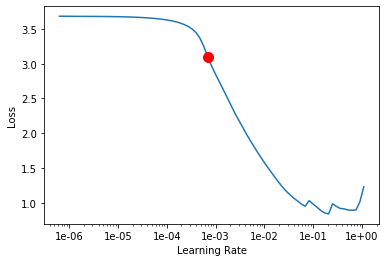

In [25]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [26]:
learner.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,time
0,-1.855527,-1.861520,01:02


In [27]:
learner.save('chiron')

In [13]:
x, y = databunch.one_batch()
y_pred = model(x.cuda()).detach().cpu().numpy()
y_pred[0,0]

array([-0.506026, -1.915522, -2.12539 , -2.039508, -7.904355], dtype=float32)

In [14]:
decoded = pop.decode(y_pred, threshold=0, beam_size=5)

In [15]:
predicted = decoded[0]
actual = pop.convert_idx_to_base_sequence(y[0])
error = pop.calc_sequence_error_metrics(actual, predicted)

In [16]:
actual, predicted

('GG-G-A----CCG-ACA-CGA-------------------------------------------------',
 'GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAG',
 tensor([3, 3, 0, 3, 0, 1, 0, 0, 0, 0, 2, 2, 3, 0, 1, 2, 1, 0, 2, 3, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))